# Car Tracking and Counting

### Introduction

This project objective is to employ an object detection and tracking model to track the cars and count the number of vehicles passing in each direction of a road. 

### Model and Approach
The model used is YOLOv8, which is a state-of-the-art, real-time object detection model. It is pre-retrained on the COCO dataset, which contains 80 classes of objects, including cars. The model is used to detect cars in the video frames, and the tracking is done using the bytetrack algorithm. The number of cars passing in each direction is counted and displayed on the screen. At the end, the results are saved in a CSV file and visualized in a graph.

## How to run the code

First, install the required packages.

In [ ]:
# !pip install -U ultralytics opencv-python

Then import the required libraries.

In [1]:
import cv2
from ultralytics import YOLO
from datetime import datetime, timedelta
from typing import List, Dict

Define the lines to count the cars in each direction.

In [2]:
# Define the horizontal and perpendicular line positions
line_position_horizontal = 800
line_position_perpendicular = 1200
frame_width = 1920
frame_height = 1080

START_POINT_HORIZONTAL = (0, line_position_horizontal)
END_POINT_HORIZONTAL = (frame_width, line_position_horizontal)
START_POINT_PERPENDICULAR = (line_position_perpendicular, 0)
END_POINT_PERPENDICULAR = (line_position_perpendicular, frame_height)

### Helper Functions

In [3]:
def initialize_video_writer(export_path: str, frame_width: int, frame_height: int) -> cv2.VideoWriter:
    """
    Initialize the video writer.
    """
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    frame_rate = 30  # Assuming 30 FPS for the video
    return cv2.VideoWriter(export_path, fourcc, frame_rate, (frame_width, frame_height))

def update_car_count_and_record_state(track_id: int, direction: str, car_counts: dict, already_counted: dict, current_time: datetime, state_changes: list):
    """
    Update the car count for the specified direction if the car hasn't been counted in that direction yet and record the state change.
    """
    if track_id not in already_counted or already_counted[track_id] != direction:
        car_counts[direction] += 1
        already_counted[track_id] = direction
        # Record the state change with a precise timestamp
        state_changes.append({'car_id': track_id, 'timestamp': current_time.strftime("%Y-%m-%d %H:%M:%S.%f"), 'state': direction})

## Car Tracking and Unique Identification Algorithm

In [4]:
def inference(model: YOLO, video_path: str, export_path: str, device: str = 'cpu', imgsz=(640,640), save: bool = True) -> List[Dict]:
    """
    Run inference on the video and export the annotated video. Returns the state changes.
    """
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    out = initialize_video_writer(export_path, frame_width, frame_height)

    # Initialize simulation variables
    start_time = datetime.strptime("19.02.2024 13:50:00", "%d.%m.%Y %H:%M:%S")  # Simulated start time
    frame_rate = 30  # Assuming 30 FPS for the video
    time_per_frame = timedelta(seconds=1/frame_rate)
    current_time = start_time

    # Initialize tracking variables
    car_positions = {}
    car_counts = {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
    already_counted = {}    # Tracks whether a car has been counted to prevent double counting
    state_changes = []  # To record state changes with timestamps

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Draw the horizontal and perpendicular lines
        cv2.line(frame, START_POINT_HORIZONTAL, END_POINT_HORIZONTAL, (0, 255, 0), 2)
        cv2.line(frame, START_POINT_PERPENDICULAR, END_POINT_PERPENDICULAR, (255, 0, 0), 2)

        # Run YOLOv8 tracking on the frame
        results = model.track(frame, classes=[2, 7], persist=True, device=device, imgsz=imgsz, conf=0.1, iou=0.5, tracker="bytetrack.yaml")   # Focusing on cars (class 2) and trucks (class 7)

        # Get the boxes and track IDs
        boxes = results[0].boxes.xywh.cpu()
        if results[0].boxes.id is not None:
            track_ids = results[0].boxes.id.int().cpu().tolist()

            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box
                center = (int(x), int(y))
                bbox_color = (255, 0, 0)  # Default color

                # Determine if the car has crossed the lines and update counts
                if track_id in car_positions:
                    prev_center = car_positions[track_id]
                    # Horizontal line crossing logic
                    if prev_center[1] < line_position_horizontal <= center[1]:
                        update_car_count_and_record_state(track_id, 'DOWN', car_counts, already_counted, current_time, state_changes)
                        bbox_color = (0, 255, 0)
                    elif prev_center[1] > line_position_horizontal >= center[1]:
                        update_car_count_and_record_state(track_id, 'UP', car_counts, already_counted, current_time, state_changes)
                        bbox_color = (0, 255, 0)
                    # Perpendicular line crossing logic
                    if prev_center[0] < line_position_perpendicular <= center[0]:
                        update_car_count_and_record_state(track_id, 'RIGHT', car_counts, already_counted, current_time, state_changes)
                        bbox_color = (255, 0, 0)
                    elif prev_center[0] > line_position_perpendicular >= center[0]:
                        update_car_count_and_record_state(track_id, 'LEFT', car_counts, already_counted, current_time, state_changes)
                        bbox_color = (255, 0, 0)

                # Update the car's current position
                car_positions[track_id] = center

                # Draw bounding box and track ID
                cv2.rectangle(frame, (int(x - w / 2), int(y - h / 2)), (int(x + w / 2), int(y + h / 2)), bbox_color, 2)
                cv2.putText(frame, f"ID: {track_id}", (int(x - w / 2), int(y - h / 2) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, bbox_color, 2)

        # Display counts and time on the video
        cv2.putText(frame, f"Up: {car_counts['UP']} Down: {car_counts['DOWN']}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Left: {car_counts['LEFT']} Right: {car_counts['RIGHT']}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, current_time.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3], (10, frame_height - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Increment the simulated time
        current_time += time_per_frame

        # Write the frame with annotations to the output video
        if save:
            out.write(frame)

    # Release the video capture and writer
    cap.release()
    out.release()

    return state_changes

Get inference from the model and save annotated video.

In [ ]:
video_path = 'video2.MOV'
export_path = 'real.mp4'

# Run inference algorithm and get the car data to analyze later
model = YOLO('yolov8m.pt')
state_changes = inference(model, video_path=video_path, export_path=export_path, device='cuda:0', imgsz=(384,640))

### Export the model to ONNX format

In [6]:
format = "onnx"
simply = True
imgsz = (384, 640)

model.export(format=format, simplify=simply, imgsz=imgsz)

Ultralytics YOLOv8.1.15 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Core(TM) i7-7700HQ 2.80GHz)

PyTorch: starting from 'yolov8m.pt' with input shape (1, 3, 384, 640) BCHW and output shape(s) (1, 84, 5040) (49.7 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: simplifying with onnxsim 0.4.35...
ONNX: export success ✅ 8.9s, saved as 'yolov8m.onnx' (98.9 MB)

Export complete (12.7s)
Results saved to /home/seekndestroy/talha/github/car-tracking-counting
Predict:         yolo predict task=detect model=yolov8m.onnx imgsz=384,640  
Validate:        yolo val task=detect model=yolov8m.onnx imgsz=384,640 data=coco.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[384, 640]' will not work. Use export 'imgsz=640' if val is required.
Visualize:       https://netron.app


'yolov8m.onnx'

## Performance Comparison between ONNX and PyTorch

In [ ]:
import time

# Load the ONNX and PyTorch models
onnx_model = YOLO('yolov8m.onnx')
pytorch_model = YOLO('yolov8m.pt')

# Set the device and image size
device = "cpu"
imgsz = (384, 640)
save = False

# Measure inference time for the ONNX model
start_time_onnx = time.time()
inference(onnx_model, video_path, "real_onnx.mp4", device=device, imgsz=imgsz, save=save)
end_time_onnx = time.time()

In [ ]:
# Repeat the process for the PyTorch model
start_time_pytorch = time.time()
inference(pytorch_model, video_path, "real_pytorch.mp4", device=device, imgsz=imgsz, save=save)
end_time_pytorch = time.time()

In [10]:
# Calculate and compare inference times
inference_time_onnx = end_time_onnx - start_time_onnx
inference_time_pytorch = end_time_pytorch - start_time_pytorch
print(f"ONNX Inference Time: {inference_time_onnx} seconds")
print(f"PyTorch Inference Time: {inference_time_pytorch} seconds")

ONNX Inference Time: 1416.9142174720764 seconds
PyTorch Inference Time: 1349.207942724228 seconds


## Save the Data to CSV and Visualize the Results

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Save the data to CSV
df = pd.DataFrame(state_changes)
df.to_csv('car_data.csv', index=False)

In [14]:
df[:5]

,car_id,timestamp,state
0,6,2024-02-19 13:50:00.566661,UP
1,14,2024-02-19 13:50:01.999980,UP
2,13,2024-02-19 13:50:03.666630,DOWN
3,18,2024-02-19 13:50:04.233291,UP
4,11,2024-02-19 13:50:04.999950,DOWN


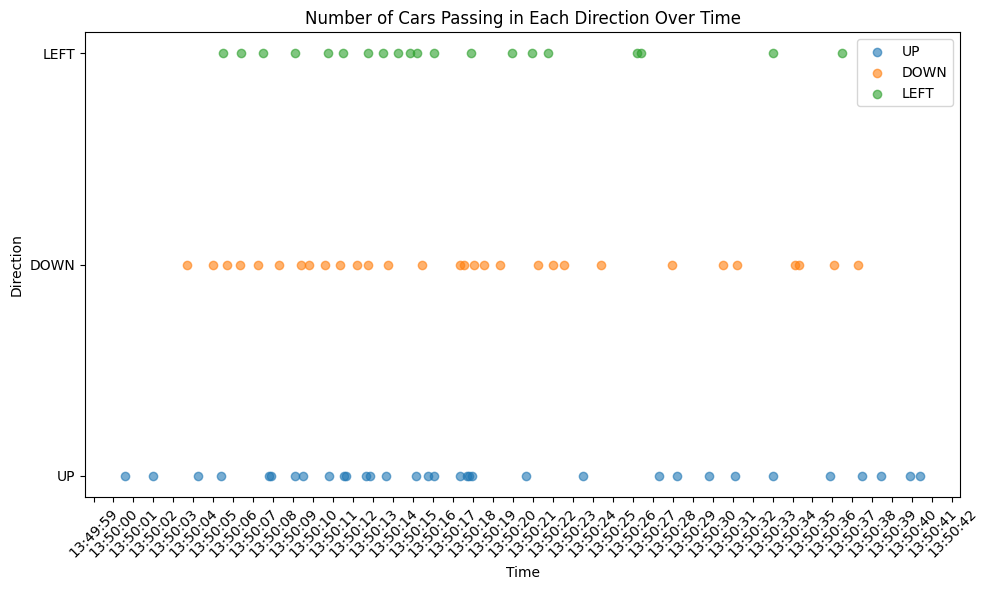

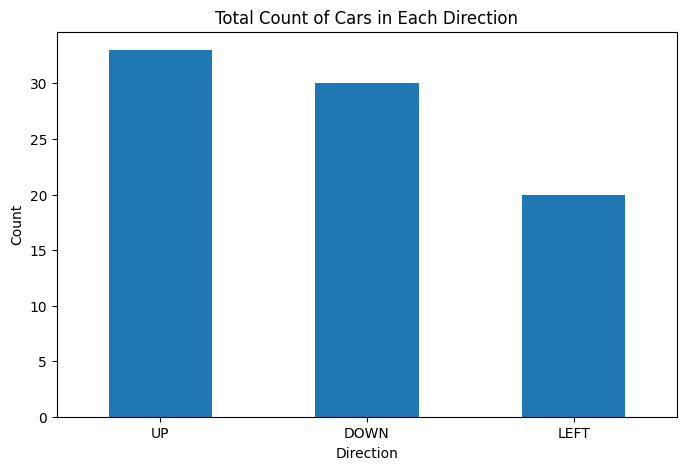

In [16]:
# Load the data
df = pd.read_csv('car_data.csv')

# Convert 'timestamp' to datetime format for easier manipulation
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Visualizing the number of cars passing in each direction over time
plt.figure(figsize=(10, 6))

# Ensure the plot displays time in seconds
locator = mdates.SecondLocator()
formatter = mdates.DateFormatter('%H:%M:%S')

for direction in df['state'].unique():
    # Filter data for each direction
    direction_data = df[df['state'] == direction]
    
    # Plot each timestamp directly without resampling
    plt.scatter(direction_data['timestamp'], direction_data['state'].apply(lambda x: direction), label=direction, alpha=0.6)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('Number of Cars Passing in Each Direction Over Time')
plt.xlabel('Time')
plt.ylabel('Direction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Visualizing the total count of cars in each direction
plt.figure(figsize=(8, 5))
df['state'].value_counts().plot(kind='bar')
plt.title('Total Count of Cars in Each Direction')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
